# 🧠 Klasifikasi Jenis Botol dengan MobileNetV2

Notebook ini bertujuan untuk mengklasifikasikan lima jenis botol menggunakan model Deep Learning MobileNetV2. 
Proses mencakup pemrosesan dataset, augmentasi, pelatihan model, evaluasi performa, dan pengujian hasil.

In [ ]:
# Import library utama
import os
import random
import shutil
from pathlib import Path
from collections import Counter

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import json
from tqdm import tqdm
from PIL import Image, ImageEnhance

# 1. Persiapan Dataset
---------------------------------
* Struktur Data
* Jumlah Data
* Format Data
* Split Data (Train 80 : Test 20)

In [2]:
# Cek posisi direktori kerja saat ini
current_dir = os.getcwd()
print("Current working directory:", current_dir)

# List semua file & folder di direktori saat ini
items = os.listdir(current_dir)
print("/nIsi folder saat ini:")
for item in items:
    print("-", item)

DATASET_PATH = Path('./Bottle Images')
print("\nDataset path yang digunakan:", DATASET_PATH)

Current working directory: C:\Users\Admin\Documents\Kode Python\Deteksi Objek
/nIsi folder saat ini:
- .ipynb_checkpoints
- Bottle Images
- cnnyolo
- Klasifikasi Jenis Botol MobileNetv2.ipynb
- requirements.txt
- Test Model.ipynb

Dataset path yang digunakan: Bottle Images


In [3]:
# Cek struktur folder dan jumlah data per kelas
print("===== Struktur Dataset dan Jumlah Data per Kelas =====")
class_folders = [f for f in DATASET_PATH.iterdir() if f.is_dir()]
print(f"Jumlah kelas (folder): {len(class_folders)}")
for folder in class_folders:
    files = list(folder.glob('*.*'))
    print(f" - {folder.name}: {len(files)} file")

# Cek format file gambar
formats = []
for folder in class_folders:
    for file in folder.iterdir():
        if file.is_file():
            formats.append(file.suffix.lower())
formats_count = Counter(formats)
print("\nFormat gambar yang ditemukan dan jumlahnya:")
for fmt, cnt in formats_count.items():
    print(f" - {fmt}: {cnt}")

===== Struktur Dataset dan Jumlah Data per Kelas =====
Jumlah kelas (folder): 5
 - Beer Bottles: 5000 file
 - Plastic Bottles: 5000 file
 - Soda Bottle: 5000 file
 - Water Bottle: 5000 file
 - Wine Bottle: 5000 file

Format gambar yang ditemukan dan jumlahnya:
 - .jpg: 25000


## 📁 Struktur Dataset

Dataset terdiri dari lima kelas:
- Beer Bottles
- Plastic Bottles
- Soda Bottles
- Water Bottles
- Wine Bottles

Setiap kelas memiliki jumlah gambar yang sama, dengan total data sebanyak 180.000 gambar (36.000 per kelas).

---------------------------------
## ✂️ Pembagian Data
---------------------------------
Data dibagi menjadi:
- 80% untuk data latih
- 20% untuk data uji

Distribusi kelas tetap seimbang setelah pembagian.

In [4]:
TRAIN_PATH = Path('./dataset_train')
TEST_PATH = Path('./dataset_test')

def split_train_test(src_path, train_path, test_path, split_ratio=0.8):
    if train_path.exists():
        shutil.rmtree(train_path)
    if test_path.exists():
        shutil.rmtree(test_path)

    train_path.mkdir(parents=True)
    test_path.mkdir(parents=True)

    for class_folder in src_path.iterdir():
        if class_folder.is_dir():
            images = list(class_folder.glob('*.*'))
            random.shuffle(images)
            train_count = int(len(images)*split_ratio)

            train_images = images[:train_count]
            test_images = images[train_count:]

            # buat folder kelas di train dan test
            (train_path / class_folder.name).mkdir(parents=True, exist_ok=True)
            (test_path / class_folder.name).mkdir(parents=True, exist_ok=True)

            # copy file ke folder train dan test
            for img in train_images:
                shutil.copy(img, train_path / class_folder.name / img.name)
            for img in test_images:
                shutil.copy(img, test_path / class_folder.name / img.name)

split_train_test(DATASET_PATH, TRAIN_PATH, TEST_PATH)

print(f"\nSplit data selesai:\n - Train: {TRAIN_PATH}\n - Test: {TEST_PATH}")

# Cek jumlah data train dan test
print("\nJumlah data per kelas setelah split:")
for folder in TRAIN_PATH.iterdir():
    print(f"Train - {folder.name}: {len(list(folder.glob('*.*')))}")
for folder in TEST_PATH.iterdir():
    print(f"Test  - {folder.name}: {len(list(folder.glob('*.*')))}")


Split data selesai:
 - Train: dataset_train
 - Test: dataset_test

Jumlah data per kelas setelah split:
Train - Beer Bottles: 4000
Train - Plastic Bottles: 4000
Train - Soda Bottle: 4000
Train - Water Bottle: 4000
Train - Wine Bottle: 4000
Test  - Beer Bottles: 1000
Test  - Plastic Bottles: 1000
Test  - Soda Bottle: 1000
Test  - Water Bottle: 1000
Test  - Wine Bottle: 1000


---------------------------------
# 2. 🔄 Augmentasi Dataset (data train saja)
---------------------------------

Augmentasi hanya diterapkan pada data latih menggunakan `ImageDataGenerator`. Teknik yang digunakan meliputi:
- Rotasi
- Zoom
- Shear
- Horizontal Flip

Tujuannya adalah memperkaya variasi data untuk meningkatkan generalisasi model.


In [5]:
# Lokasi dataset split hasil train-test
src_dir = Path("dataset_train")
dst_dir = Path("dataset_augmented")

# Bersihkan folder target jika sudah ada
if dst_dir.exists():
    shutil.rmtree(dst_dir)
dst_dir.mkdir(parents=True, exist_ok=True)

# Aturan augmentasi
angles = [15, 30, 45, 60]
flips = ['horizontal', 'vertical']

# Ambil nama class dari struktur folder
class_folders = [f.name for f in src_dir.iterdir() if f.is_dir()]

def augment_and_save_images(src_dir, dst_dir):
    for cls in class_folders:
        src_cls_dir = src_dir / cls
        dst_cls_dir = dst_dir / cls
        dst_cls_dir.mkdir(parents=True, exist_ok=True)

        image_files = list(src_cls_dir.glob("*"))

        print(f"Augmenting class '{cls}' with {len(image_files)} images...")

        for img_path in tqdm(image_files, desc=f"Processing {cls}"):
            img = Image.open(img_path).convert("RGB")
            img_name = img_path.stem

            # Simpan original
            img.save(dst_cls_dir / f"{img_name}_orig.jpg")

            # Rotate
            for angle in angles:
                rotated = img.rotate(angle)
                rotated.save(dst_cls_dir / f"{img_name}_rot{angle}.jpg")

            # Flip
            flipped_h = img.transpose(Image.FLIP_LEFT_RIGHT)
            flipped_h.save(dst_cls_dir / f"{img_name}_fliph.jpg")

            flipped_v = img.transpose(Image.FLIP_TOP_BOTTOM)
            flipped_v.save(dst_cls_dir / f"{img_name}_flipv.jpg")

            # Brightness
            enhancer = ImageEnhance.Brightness(img)
            bright = enhancer.enhance(np.random.uniform(0.8, 1.2))
            bright.save(dst_cls_dir / f"{img_name}_bright.jpg")

            # Zoom: crop center dan resize kembali
            width, height = img.size
            crop_scale = 0.8
            left = int(width * (1 - crop_scale) / 2)
            top = int(height * (1 - crop_scale) / 2)
            right = int(width * (1 + crop_scale) / 2)
            bottom = int(height * (1 + crop_scale) / 2)
            cropped = img.crop((left, top, right, bottom)).resize((width, height))
            cropped.save(dst_cls_dir / f"{img_name}_zoom.jpg")

    print("\n✅ Augmentasi selesai. Semua data disimpan di:", dst_dir)

    # Hitung jumlah file hasil augmentasi per kelas
    print("\n📊 Ringkasan Jumlah File Hasil Augmentasi:")
    total = 0
    for cls in class_folders:
        count = len(list((dst_dir / cls).glob("*")))
        print(f"- {cls}: {count} file")
        total += count
    print(f"\n🧮 Total keseluruhan file hasil augmentasi: {total}")

# Jalankan augmentasi
augment_and_save_images(src_dir, dst_dir)

Augmenting class 'Beer Bottles' with 4000 images...


Processing Beer Bottles: 100%|█████████████████████████████████████████████████████| 4000/4000 [02:44<00:00, 24.26it/s]


Augmenting class 'Plastic Bottles' with 4000 images...


Processing Plastic Bottles: 100%|██████████████████████████████████████████████████| 4000/4000 [02:47<00:00, 23.91it/s]


Augmenting class 'Soda Bottle' with 4000 images...


Processing Soda Bottle: 100%|██████████████████████████████████████████████████████| 4000/4000 [01:25<00:00, 46.74it/s]


Augmenting class 'Water Bottle' with 4000 images...


Processing Water Bottle: 100%|█████████████████████████████████████████████████████| 4000/4000 [01:26<00:00, 46.29it/s]


Augmenting class 'Wine Bottle' with 4000 images...


Processing Wine Bottle: 100%|██████████████████████████████████████████████████████| 4000/4000 [01:28<00:00, 45.42it/s]



✅ Augmentasi selesai. Semua data disimpan di: dataset_augmented

📊 Ringkasan Jumlah File Hasil Augmentasi:
- Beer Bottles: 36000 file
- Plastic Bottles: 36000 file
- Soda Bottle: 36000 file
- Water Bottle: 36000 file
- Wine Bottle: 36000 file

🧮 Total keseluruhan file hasil augmentasi: 180000


---------------------------------
# 3. Architecture Model: MobileNetV2 Transfer Learning
---------------------------------

## 🧠 Arsitektur Model: MobileNetV2

Model berbasis transfer learning MobileNetV2 digunakan sebagai fitur ekstraktor. Beberapa layer tambahan ditambahkan:
- GlobalAveragePooling
- Dense layer dengan Softmax (5 output untuk 5 kelas)

Model di-*fine-tune* pada data klasifikasi botol.

In [6]:
# Paths
AUGMENTED_PATH = Path('./dataset_augmented')
TEST_PATH = Path('./dataset_test')

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = len(list(AUGMENTED_PATH.iterdir()))

# Data generator untuk augmented dataset dan test dataset
train_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)
test_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

train_ds = train_gen.flow_from_directory(
    AUGMENTED_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

test_ds = test_gen.flow_from_directory(
    TEST_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(train_ds.class_indices)

# Save class indices
with open('class_indices.json', 'w') as f:
    json.dump(train_ds.class_indices, f)
    
# Build model MobileNetV2 dengan transfer learning
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,),
                         include_top=False,
                         weights='imagenet')

x = base_model.output
x = GlobalAveragePooling2D()(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs, name="MobileNetv2_Model")

# Freeze base model agar tidak dilatih ulang
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Found 180000 images belonging to 5 classes.
Found 5000 images belonging to 5 classes.
{'Beer Bottles': 0, 'Plastic Bottles': 1, 'Soda Bottle': 2, 'Water Bottle': 3, 'Wine Bottle': 4}


Model: "MobileNetv2_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

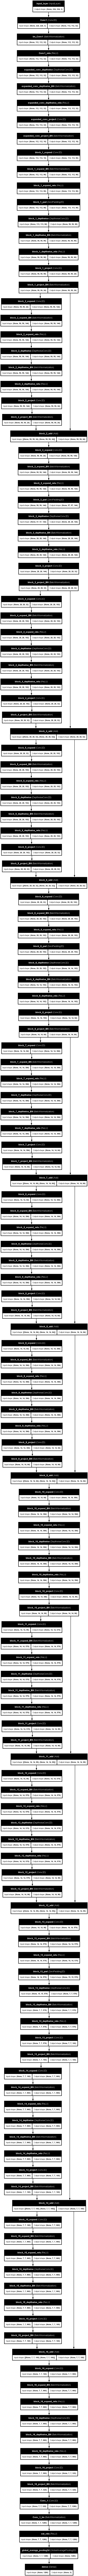

In [7]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display

# Simpan visualisasi model ke file PNG
plot_model(model, to_file='mobilenetv2_model.png', show_shapes=True, show_layer_names=True)

# Tampilkan langsung di notebook
display(Image(filename='mobilenetv2_model.png'))

---------------------------------
# 4. Training Model
---------------------------------

## 🏋️ Proses Pelatihan

Model dilatih menggunakan:
- Optimizer: Adam
- Loss Function: Categorical Crossentropy
- Metric: Accuracy

Hasil pelatihan ditampilkan dalam bentuk grafik akurasi dan loss.

In [8]:
import datetime
import time
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, Callback

# 0. Callback untuk mencatat waktu setiap epoch
class TimingCallback(Callback):
    def __init__(self, log_path="epoch_times.txt"):
        super().__init__()
        self.log_path = log_path
        self.epoch_times = []

        folder = os.path.dirname(self.log_path)
        if folder != "":
            os.makedirs(folder, exist_ok=True)

        # Kosongkan isi file lama jika ada
        with open(self.log_path, 'w', encoding="utf-8") as f:
            f.write("Epoch Timing Log\n")
            f.write("================\n")

    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        elapsed = time.time() - self.start_time
        self.epoch_times.append(elapsed)
        log_line = f"Epoch {epoch + 1} time: {elapsed:.2f} seconds"
        print("⏱️", log_line)

        # Simpan ke file log
        with open(self.log_path, 'a', encoding="utf-8") as f:
            f.write(log_line + "\n")

    def on_train_end(self, logs=None):
        avg_time = sum(self.epoch_times) / len(self.epoch_times)
        result_line = f"\n✅ Average epoch time: {avg_time:.2f} seconds"
        print(result_line)

        # Simpan juga ke file log
        with open(self.log_path, 'a', encoding="utf-8") as f:
            f.write(result_line + "\n")


# 1. Buat folder log dengan timestamp untuk TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# 2. Inisialisasi semua callbacks
timing = TimingCallback(log_path="logs/epoch_times.txt")

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('mobilenetv2.keras', monitor='val_accuracy', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    TensorBoard(log_dir=log_dir, histogram_freq=1),
    timing
]

history = model.fit(
    train_ds,
    epochs=1000,
    validation_data=test_ds,
    callbacks=callbacks
)

C:\Users\Admin\Documents\Kode Python\Deteksi Objek\cnnyolo\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/1000
⏱️ Epoch 1 time: 3875.48 seconds━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.9253 - loss: 0.2138   
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 3875s 688ms/step - accuracy: 0.9253 - loss: 0.2138 - val_accuracy: 0.9690 - val_loss: 0.0912 - learning_rate: 0.0010
Epoch 2/1000
⏱️ Epoch 2 time: 2879.13 seconds━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.9677 - loss: 0.0905   
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 2879s 512ms/step - accuracy: 0.9677 - loss: 0.0905 - val_accuracy: 0.9718 - val_loss: 0.0876 - learning_rate: 0.0010
Epoch 3/1000
⏱️ Epoch 3 time: 2918.53 seconds━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.9718 - loss: 0.0777   
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 2919s 519ms/step - accuracy: 0.9718 - loss: 0.0777 - val_accuracy: 0.9672 - val_loss: 0.0947 - learning_rate: 0.0010
Epoch 4/1000
⏱️ Epoch 4 time: 3041.65 seconds━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.9729 - loss: 0.0738   
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 3042s 541ms/step - accuracy: 0.9729 - loss: 0.0738 - val_accuracy: 0.9658 - val_loss: 0.0992 

---------------------------------
# 5. Evaluasi Model
---------------------------------

## 📊 Evaluasi Model

Model dievaluasi pada data uji menggunakan:
- Akurasi
- Confusion Matrix
- Classification Report

Hasil evaluasi menunjukkan performa model dalam mengklasifikasikan jenis botol.

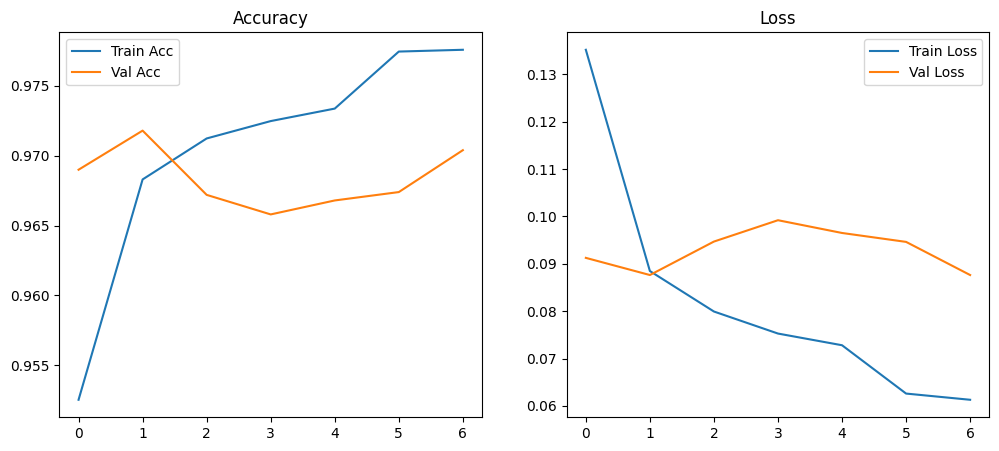

In [9]:
# Plot akurasi dan loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()

157/157 ━━━━━━━━━━━━━━━━━━━━ 75s 469ms/step 

Classification Report:

                 precision    recall  f1-score   support

   Beer Bottles       0.94      0.99      0.97      1000
Plastic Bottles       1.00      0.99      0.99      1000
    Soda Bottle       0.97      0.95      0.96      1000
   Water Bottle       0.99      0.98      0.98      1000
    Wine Bottle       0.96      0.95      0.96      1000

       accuracy                           0.97      5000
      macro avg       0.97      0.97      0.97      5000
   weighted avg       0.97      0.97      0.97      5000



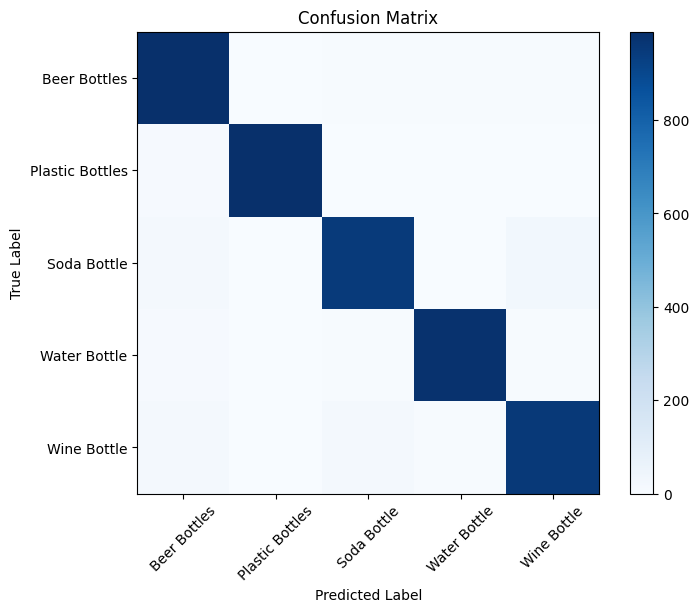

In [10]:
# Prediksi dan confusion matrix
test_steps = test_ds.samples // test_ds.batch_size + 1
pred_prob = model.predict(test_ds, steps=test_steps)
pred_labels = np.argmax(pred_prob, axis=1)
true_labels = test_ds.classes

print("\nClassification Report:\n")
print(classification_report(true_labels, pred_labels, target_names=list(test_ds.class_indices.keys())))

cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(NUM_CLASSES)
plt.xticks(tick_marks, list(test_ds.class_indices.keys()), rotation=45)
plt.yticks(tick_marks, list(test_ds.class_indices.keys()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

------------------
# 6 Fine Tuning
------------------

In [11]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path

# 1. Path dan parameter
AUGMENTED_PATH = Path('./dataset_augmented')
TEST_PATH = Path('./dataset_test')

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# 2. Data generator
train_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)
test_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

train_ds = train_gen.flow_from_directory(
    AUGMENTED_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

test_ds = test_gen.flow_from_directory(
    TEST_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# 3. Load model hasil training tahap 1 (feature extraction)
model = load_model('mobilenetv2.keras')

# 4. Cek arsitektur model
model.summary()

Found 180000 images belonging to 5 classes.
Found 5000 images belonging to 5 classes.


Model: "MobileNetv2_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,277,201 (8.69 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 12,812 (50.05 KB)

In [12]:
# 5. Unfreeze seluruh layer (atau hanya sebagian jika ingin)
for layer in model.layers:
    layer.trainable = True  # kamu juga bisa unfreeze sebagian saja jika ingin

# 6. Re-compile model dengan learning rate kecil untuk fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "MobileNetv2_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 2,230,277 (8.51 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [13]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('mobilenetv2-tuning.keras', monitor='val_accuracy', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    TensorBoard(log_dir=log_dir, histogram_freq=1),
    timing
]
# 7. Fine-tune model
history = model.fit(
    train_ds,
    epochs=1000,
    validation_data=test_ds,
    callbacks=callbacks
)

Epoch 1/1000


C:\Users\Admin\Documents\Kode Python\Deteksi Objek\cnnyolo\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


⏱️ Epoch 1 time: 15460.29 seconds━━━━━━━━━━ 0s 3s/step - accuracy: 0.9498 - loss: 0.1552     
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 15460s 3s/step - accuracy: 0.9498 - loss: 0.1552 - val_accuracy: 0.9966 - val_loss: 0.0131 - learning_rate: 1.0000e-05
Epoch 2/1000
⏱️ Epoch 2 time: 15291.34 seconds━━━━━━━━━━ 0s 3s/step - accuracy: 0.9970 - loss: 0.0090     
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 15291s 3s/step - accuracy: 0.9970 - loss: 0.0090 - val_accuracy: 0.9960 - val_loss: 0.0097 - learning_rate: 1.0000e-05
Epoch 3/1000
⏱️ Epoch 3 time: 15304.00 seconds━━━━━━━━━━ 0s 3s/step - accuracy: 0.9988 - loss: 0.0037     
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 15304s 3s/step - accuracy: 0.9988 - loss: 0.0037 - val_accuracy: 0.9974 - val_loss: 0.0116 - learning_rate: 1.0000e-05
Epoch 4/1000
⏱️ Epoch 4 time: 15997.22 seconds━━━━━━━━━━ 0s 3s/step - accuracy: 0.9993 - loss: 0.0018     
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 15997s 3s/step - accuracy: 0.9993 - loss: 0.0018 - val_accuracy: 0.9986 - val_loss: 0.0062 - learning_ra

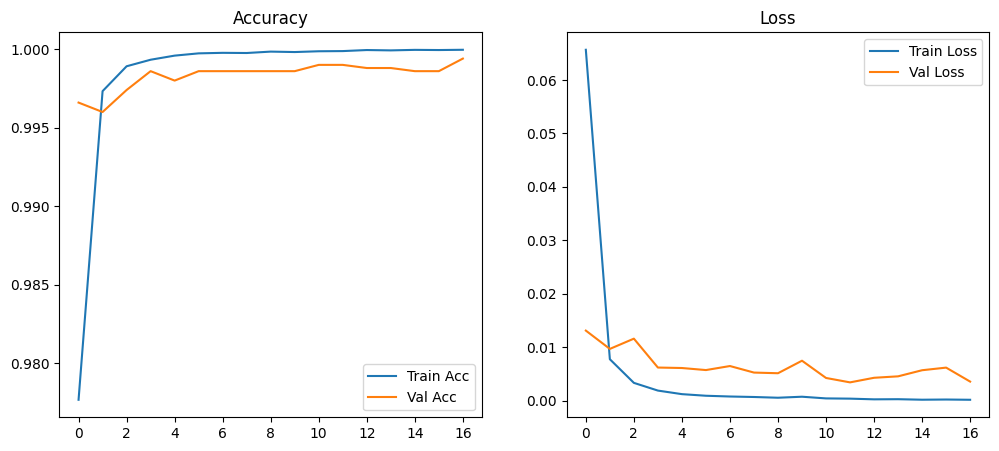

In [14]:
# Plot akurasi dan loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()

---------------------
# 7. Testing Tuning Model
---------------------

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import random
import shutil
from pathlib import Path
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf

model = load_model('mobilenetv2-tuning.keras')
model.summary()

Model: "MobileNetv2_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 6,724,945 (25.65 MB)

 Trainable params: 2,230,277 (8.51 MB)

 Non-trainable params: 34,112 (133.25 KB)

 Optimizer params: 4,460,556 (17.02 MB)

In [2]:
# Paths
TEST_PATH = Path('./dataset_test')
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data generator untuk augmented dataset dan test dataset
test_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

test_ds = test_gen.flow_from_directory(
    TEST_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(test_ds.class_indices)

Found 5000 images belonging to 5 classes.
{'Beer Bottles': 0, 'Plastic Bottles': 1, 'Soda Bottle': 2, 'Water Bottle': 3, 'Wine Bottle': 4}


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━

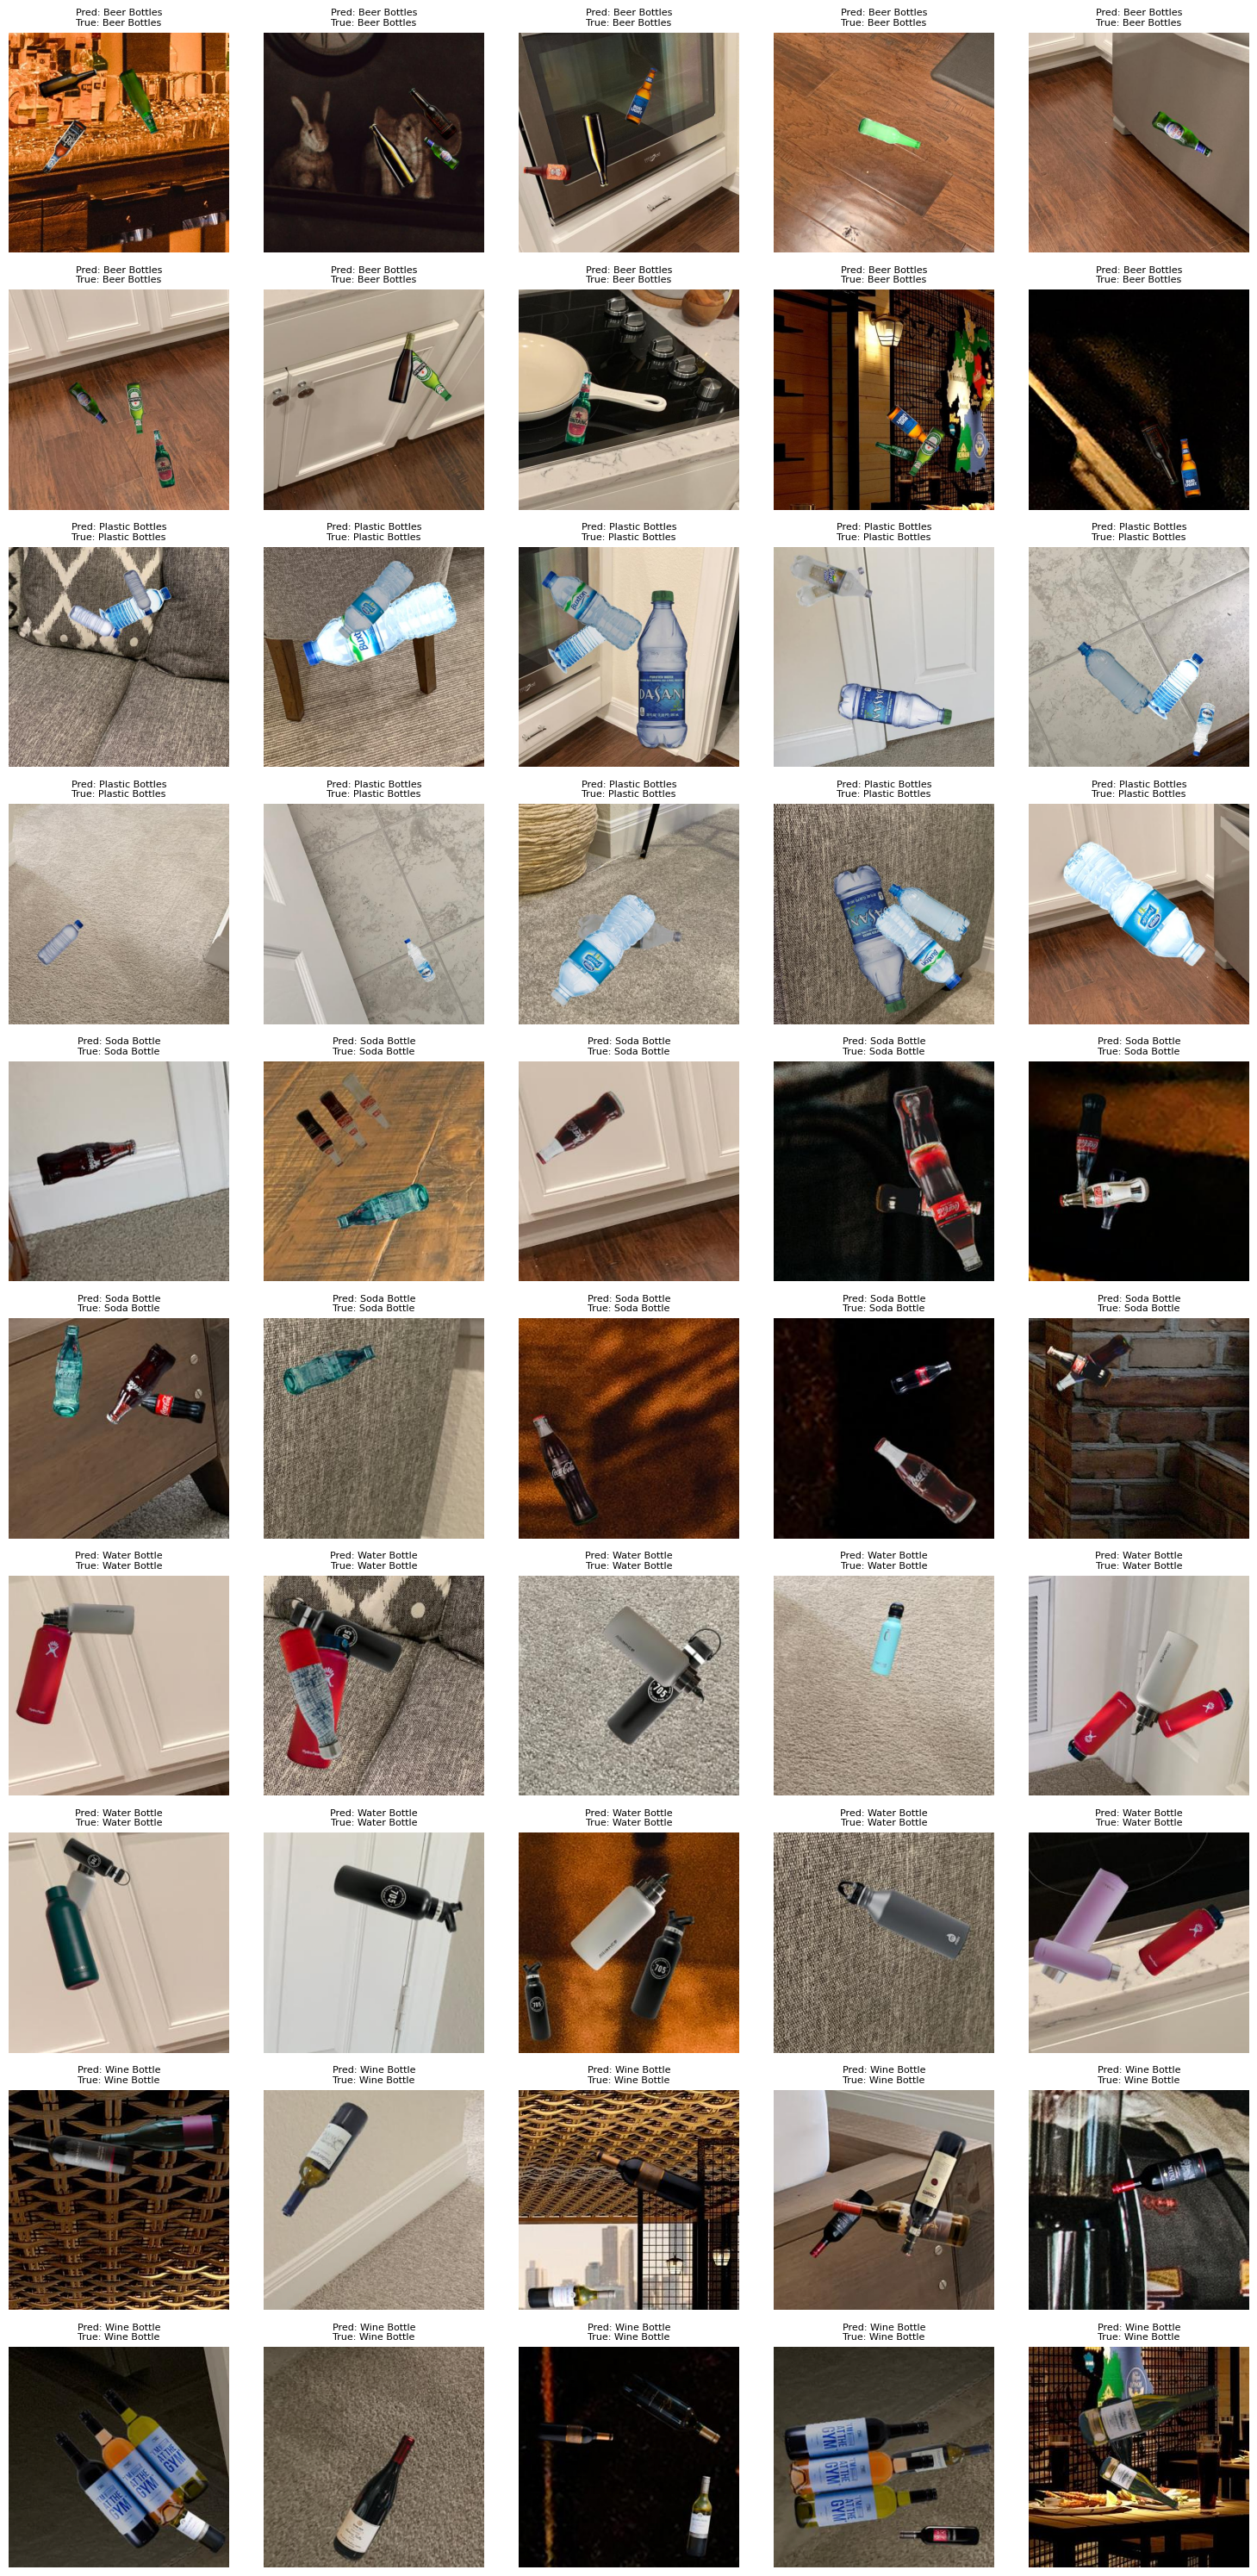

In [3]:
# Mapping label dari dataset test (jika pakai ImageDataGenerator sebelumnya)
class_indices = test_ds.class_indices
labels = dict((v, k) for k, v in class_indices.items())

# Ambil 5 gambar dari setiap kelas
sample_images = []
for class_name in os.listdir(TEST_PATH):
    class_folder = os.path.join(TEST_PATH, class_name)
    if os.path.isdir(class_folder):
        imgs = os.listdir(class_folder)
        selected_imgs = random.sample(imgs, min(10, len(imgs)))  # Ubah Disini untuk jumlah data Test
        for img in selected_imgs:
            sample_images.append((os.path.join(class_folder, img), class_name))

# Tampilkan dan prediksi semua gambar
plt.figure(figsize=(15, len(sample_images) // 5 * 3))  # Dinamis berdasarkan jumlah gambar
for i, (img_path, true_label) in enumerate(sample_images):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)
    pred_label = labels[np.argmax(pred)]

    plt.subplot(len(sample_images) // 5, 5, i + 1)
    plt.imshow(image.load_img(img_path))
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

## ✅ Kesimpulan

Model MobileNetV2 mampu mengenali jenis botol dengan akurasi tinggi. Langkah lanjutan yang bisa dilakukan:
- Uji model dengan data nyata
- Integrasi model ke dalam aplikasi web
- Optimasi dan konversi model ke format yang ringan (misalnya: `.tflite`)